# Image time frame normalization approach

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten, Dropout
from sys import getsizeof
from sklearn.metrics import mean_squared_error
from math import sqrt

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data extraction methods

In [18]:
# Where you put the image file,
# It can be either relative or absolute path
image_folder = "MultiModHandGestUAV"

#Weights Directory
WEIGHTS_FOLDER = "ChiCheng's_Weights"

#Input shpae, 120 rows, 320 columns. Each cell has 1 dimension of colour
INPUT_SHAPE = (120,320,1)

# All subjects available
SUBJECT_NUMBERS = tuple(i for i in range(0,13))

#No. of subjects to train at once due to memory constraint
#Doesn't affect test data sets
SUBJECTS_PER_ITER = 5

#Exclude the "ele" label for now.
GOOD_LABELS = {"cam_b", "cam_f", "cam_l", "cam_r", "down", "left", "right", "up", "zoom_in", "zoom_out"}

#Show a few images each time image file are read
IMAGES_TO_SHOW = 5



def _break_down_path(image_path):
    """
    Break down the path image_path into 5 components and return them:
    1. subject: the subject number (in str) 
    2. is_sequence = "sequence" if not static image
    3. label: Which action the sequence is 
    4. typ: either "train" or "test"
    5. sequence_no, "seq_x"
    **Please note if the folder is for static images, the components break-down 
      will not be correct. You can check if sequence_no starts with "seq_" for confirmation 
    """
    #Image_path looks like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    image_path, sequence_no = os.path.split(image_path)
    image_path, typ = os.path.split(image_path)
    image_path, label = os.path.split(image_path)
    image_path, is_sequence = os.path.split(image_path)
    _, subject = os.path.split(image_path)
    return subject, is_sequence, label, typ, sequence_no


def get_seq_path(subject_nos=None, gesture_names=None, target_type = "train"):
    """
    Given an array of numbers in subject_nos, or names in gesture_names
    returns a list where each row is tuple(image_fullpath, label, seq_uid, which_frame, total_frame_in_sequence)
    seq_uid = subject_number + sequence_no + label, used to uniquely identify a sequence.
    """
    result = []
    
    #Path would look like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    for folder, sub_folders, files in os.walk(image_folder):
        if len(sub_folders) == 0 and len(files) > 0:  #Reached a folder with no subfolder
            subject, is_sequence, label, typ, sequence_no = _break_down_path(folder)
            
            if sequence_no.startswith("seq_") and \
                (int(subject) in subject_nos if subject_nos is not None else True) and \
                (label in gesture_names if gesture_names is not None else True) and \
                typ == target_type:
                num_files = len(files)
                seq_uid = "%s|%s|%s" % (subject, sequence_no, label)
                for i in range(num_files):
                    result.append(tuple([os.path.join(folder, files[i]), label, seq_uid, i ,num_files]))
    return result


def read_image(fullpath):
    """
    Read a single image specified fullpath
    """
    img = Image.open(fullpath).convert('L')
    img = img.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))
    result = np.array(img).reshape(INPUT_SHAPE) / 255.0
    return result


def process_image_rows(image_file_data):
    """
    Read the tuple list returned by get_seq_path and convert them into x, y, l np_arry
    where x is the np array of all images, l is the label array, and y is the normalized timestamp
    """
    #each row is tuple(image_fullpath, label, which_frame, total_frame_in_sequence)
    x = []
    y = []
    l = []
    
    for row in image_file_data:
        x.append(read_image(row[0]))
        y.append(row[3]/row[4])
        l.append(row[1])
    
    x = np.array(x, dtype="float32")
    y = np.array(y, dtype="float32")
    l = np.array(l)
    
    return x, y, l

def get_image_data(subject_nos=None, gesture_names=None, target_type = "train"):
    """
    Given the subject number, gestures names, and training or test,
    return a np array respresentation of that data.
    Return x, y, l = labels, s = unique sequence ID
    """
    image_data = get_seq_path(subject_nos, gesture_names, target_type)
    x, y, l = process_image_rows(image_data)
    s = np.array(image_data)[:,2]
    return x, y, l, s

## Create 11 models, one for each gesture
All models can be accessed in models, which is dict. Keys are label names.

In [3]:
#Print the mode summary only once
first_print = True

models = {}
for a_label in GOOD_LABELS:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1) , activation='relu',input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(10,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    if first_print:
        print(model.summary())
        first_print = False
    if first_print:
        print(model.summary())
        first_print = False
    model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())
    models[a_label] = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 117, 317, 64)      1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 158, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 154, 64)       102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 77, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 73, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 32, 64)         102464    
__________

## Get Train Data and fit model iteratively
Due to memory constraint, we shall do it SUBJECTS_PER_ITER subjects at a time.
Try to make this work even if you have only 16GB RAM.

Be care with memory management. Release whatever you don't need.

Getting training data for subject(s) 0,1,2,3,4
X Train shape: (24564, 120, 320, 1)
Show a few training images:


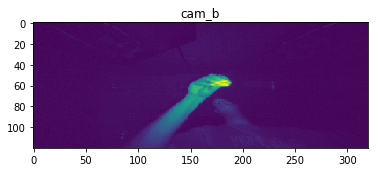

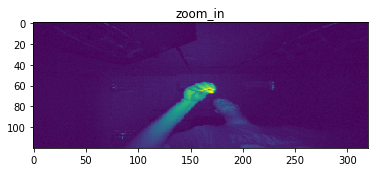

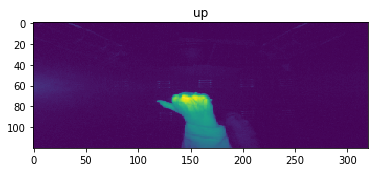

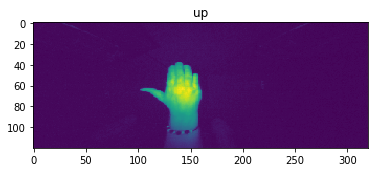

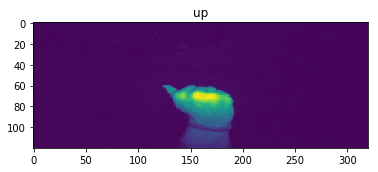

2184 entries with label "cam_l" are found.
Epoch 1/20
2184/2184 [==============================] - 13s 6ms/step - loss: 0.0803
Epoch 2/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0237
Epoch 3/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0171
Epoch 4/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0144
Epoch 5/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0139
Epoch 6/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0122
Epoch 7/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0119
Epoch 8/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0109
Epoch 9/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0101
Epoch 10/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0095
Epoch 11/20
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0090
Epoch 12/20
2184/2184 [==================

Epoch 1/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0412
Epoch 2/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0258
Epoch 3/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0237
Epoch 4/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0228
Epoch 5/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 6/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0192
Epoch 7/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0188A: 2s - los
Epoch 8/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0167
Epoch 9/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0150
Epoch 10/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0136A: 0s - lo
Epoch 11/20
2954/2954 [==============================] - 9s 3ms/step - loss: 0.0127
Epoch 12/20
2954/2954 [==============================] - 9s 3ms/

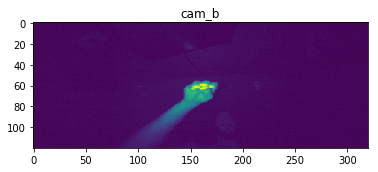

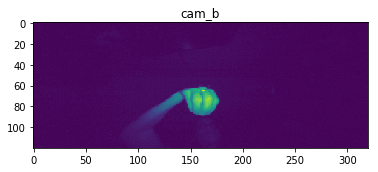

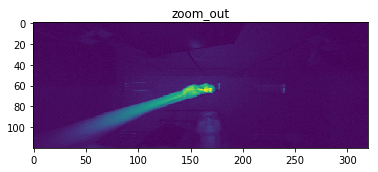

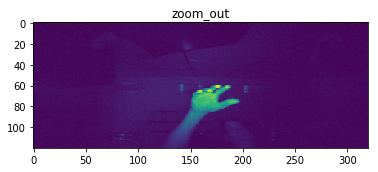

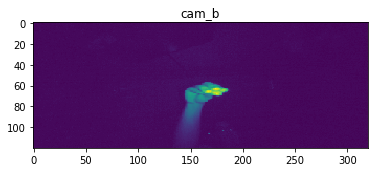

2713 entries with label "cam_l" are found.
Epoch 1/20
2713/2713 [==============================] - 9s 3ms/step - loss: 0.0290
Epoch 2/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0195
Epoch 3/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0180
Epoch 4/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0162
Epoch 5/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0146
Epoch 6/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0138
Epoch 7/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0120A: 0s - l
Epoch 8/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0112
Epoch 9/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0092
Epoch 10/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0088
Epoch 11/20
2713/2713 [==============================] - 8s 3ms/step - loss: 0.0081
Epoch 12/20
2713/2713 [==========

2602/2602 [==============================] - 8s 3ms/step - loss: 0.0022
sqrt(MSE) is  0.051830555522166366
---------------------------------------------
2768 entries with label "down" are found.
Epoch 1/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0241
Epoch 2/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0147
Epoch 3/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0115
Epoch 4/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0096
Epoch 5/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0080
Epoch 6/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0073
Epoch 7/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0059
Epoch 8/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0057
Epoch 9/20
2768/2768 [==============================] - 8s 3ms/step - loss: 0.0050
Epoch 10/20
2768/2768 [==============================] - 8

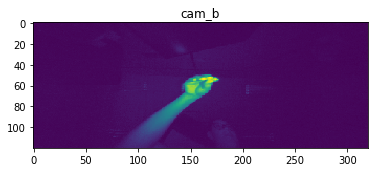

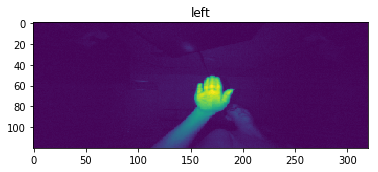

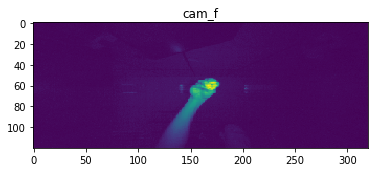

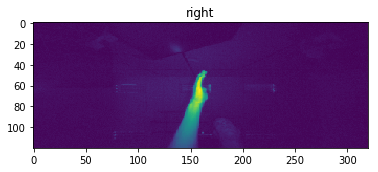

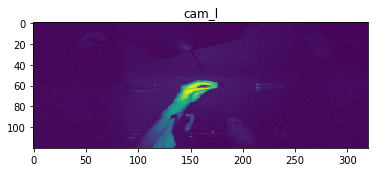

1594 entries with label "cam_l" are found.
Epoch 1/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0209
Epoch 2/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0131
Epoch 3/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0111
Epoch 4/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0092
Epoch 5/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0076
Epoch 6/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0064
Epoch 7/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0051
Epoch 8/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0045
Epoch 9/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0040
Epoch 10/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0032A: 0s - 
Epoch 11/20
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0029
Epoch 12/20
1594/1594 [===========

1397/1397 [==============================] - 4s 3ms/step - loss: 0.0211A: 0s - loss
Epoch 2/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0119
Epoch 3/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0087
Epoch 4/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0061A: 0s - 
Epoch 5/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0055
Epoch 6/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0044
Epoch 7/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0038
Epoch 8/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 9/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0024
Epoch 10/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0023
Epoch 11/20
1397/1397 [==============================] - 4s 3ms/step - loss: 0.0021
Epoch 12/20
1397/1397 [==============================] - 4s 3ms/step - loss:

In [4]:
for i in range(min(SUBJECT_NUMBERS),max(SUBJECT_NUMBERS) // SUBJECTS_PER_ITER + 1):
    subject_nos = [j for j in range(i * SUBJECTS_PER_ITER, (i + 1) * SUBJECTS_PER_ITER)\
                   if j in SUBJECT_NUMBERS]
    
    print("Getting training data for subject(s) %s" % ",".join([str(j) for j in subject_nos]))
    x_train, y_train, l_train, _ = get_image_data(subject_nos, GOOD_LABELS, "train")
    print("X Train shape:", x_train.shape)
    
    print("Show a few training images:")
    for i in range(0, IMAGES_TO_SHOW):
        plt.imshow(x_train[int(x_train.shape[0] / IMAGES_TO_SHOW * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
        plt.title(l_train[int(x_train.shape[0] / IMAGES_TO_SHOW * i)])
        plt.show()
    
    for a_label in GOOD_LABELS:
        row_nos = np.where(l_train == a_label)
        print("%d entries with label \"%s\" are found." %(row_nos[0].shape[0], a_label,))
        models[a_label].fit(x_train[row_nos],
                            y_train[row_nos], batch_size = 10, epochs=20)
        y_pred = models[a_label].predict(x_train[row_nos])
        print("sqrt(MSE) is ", sqrt(mean_squared_error(y_pred.ravel(), y_train[row_nos])))
        print("---------------------------------------------")
    
    #Relase the memory, as we no longer need the training data
    del x_train, y_train,l_train
    print("***********************************************************\n")

## Get Test Data

In [5]:
image_data = get_seq_path(subject_nos=[0,1,], target_type="test")
test_image_data = np.array(image_data)

x_test, y_test, l_test = process_image_rows(image_data)

print("X Test shape:", x_test.shape)

X Test shape: (2935, 120, 320, 1)


## Read Testing data
Currently for test data, all images are read at once.

Print a few test Images:


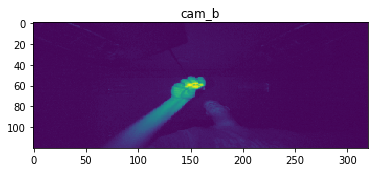

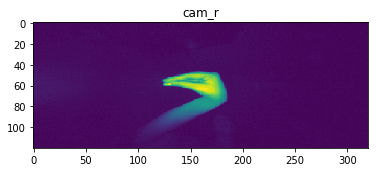

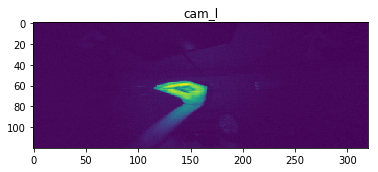

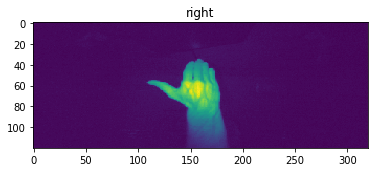

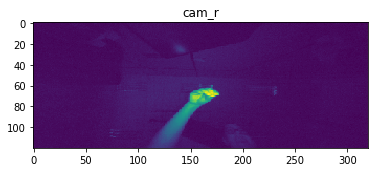

In [6]:
x_test, y_test, l_test, s_test = get_image_data(SUBJECT_NUMBERS, GOOD_LABELS, "test")
print("Print a few test Images:")
for i in range(0, IMAGES_TO_SHOW):
    plt.imshow(x_test[int(x_test.shape[0] / IMAGES_TO_SHOW * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
    plt.title(l_test[int(x_test.shape[0] / IMAGES_TO_SHOW * i)])
    plt.show()


## Get test prediction

In [7]:
all_seqs = tuple(np.unique(s_test))
right = 0
wrong = 0
aaa = {}
bbb = {}
for a_seq in all_seqs:
    matching_indices = np.where(s_test == a_seq)
    
    mse = {}
    lab = tuple(np.unique(l_test[matching_indices]))
    
    for a_label in GOOD_LABELS:
        y_pred = models[a_label].predict(x_test[matching_indices])
        mse[a_label] = mean_squared_error(y_pred.ravel(), y_test[matching_indices])
    
    if min(mse, key=mse.get) == lab[0]:
        right += 1
    else:
        wrong += 1
        
        if lab[0] in aaa:
            aaa[lab[0]] += 1
        else:
            aaa[lab[0]] = 1
            
        if min(mse, key=mse.get) in bbb:
            bbb[min(mse, key=mse.get)] += 1
        else:
            bbb[min(mse, key=mse.get)] = 1

In [10]:
print(right, wrong, right/(right+wrong))

print(aaa, bbb)

730 169 0.8120133481646273
{'down': 39, 'up': 27, 'cam_b': 19, 'zoom_out': 24, 'cam_l': 16, 'zoom_in': 19, 'cam_f': 6, 'right': 10, 'cam_r': 9} {'up': 47, 'zoom_out': 17, 'zoom_in': 2, 'left': 10, 'cam_b': 12, 'cam_r': 17, 'cam_l': 15, 'down': 20, 'right': 12, 'cam_f': 17}


In [9]:
del x_test, y_test, l_test, s_test

In [21]:
def save_models(models):
    if not os.path.exists(WEIGHTS_FOLDER):
        os.mkdir(WEIGHTS_FOLDER)
        
    for l in models:
        models[l].save_weights(os.path.join(WEIGHTS_FOLDER, "%s_chicheng.wgh" % l))
        
def load_models(models):
    for l in models:
        models[l].load_weights(os.path.join(WEIGHTS_FOLDER), "%s_chicheng.wgh" % l)

In [22]:
#save_models(models)

In [ ]:
#load_models(models)